# ReZero by Examples 
 # Training 128 layer ReZero Transformer on WikiText-2 language modeling

In this notebook we will examine how the [ReZero](https://arxiv.org/abs/2003.04887) architecture addition enables or accelerates training in deep [Transformer](https://arxiv.org/pdf/1706.03762.pdf) networks or fully connected networks.

The official ReZero repo is [here](https://github.com/majumderb/rezero). Although it is not required for this notebook, you can install ReZero for PyTorch Transformers via
```
pip install rezero
```

Running time of the notebook: 7 minutes on laptop with single RTX 2060 GPU (+ 21 minutes for training 128 layer transformer at the end)

As a simple illustration of the power of ReZero we will now train a 128 layer ReZero-Transformer network on a sequence-to-sequence model, and explore why this is not possible with the vanilla Transformer architecture. This discussion is based to the basic PyTorch tutorial [Sequence-to-Sequence Modeling with nn.Transformer and TorchText
](https://pytorch.org/tutorials/beginner/transformer_tutorial.html).


Before we build the model, let us define the `ReZeroEncoderLayer` following the default PyTorch implementation, but adding a residual weight (default = 0) that by default initializes this layer as the identity map. 

We also add arguments for pre-residual and post-residual LayerNorm applications. Using post-norm and seting the residual weight to 1 reproduces the standard encoder layer. We will explore the impact of various configurations on signal propagation.

In [1]:
######################################################################
# Import and set manual seed


import numpy as np
import time
import math
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from torch.nn.modules.module import Module
from torch.nn.modules.activation import MultiheadAttention
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torch.nn.init import xavier_uniform_

torch.manual_seed(0)

######################################################################
# Define the ReZero Transformer


class ReZeroEncoderLayer(Module):
    r"""ReZero-TransformerEncoderLayer is made up of self-attn and feedforward network.

    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of intermediate layer, relu or gelu (default=relu).
        use_LayerNorm: using either no LayerNorm (dafault=False), or use LayerNorm "pre", or "post"

    Examples::
        >>> encoder_layer = ReZeroEncoderLayer(d_model=512, nhead=8)
        >>> src = torch.rand(10, 32, 512)
        >>> out = encoder_layer(src)
    """

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation = "relu", 
                 use_LayerNorm = False, init_resweight = 0, resweight_trainable = True):
        super(ReZeroEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        
        # Definte the Resisdual Weight for ReZero
        self.resweight = torch.nn.Parameter(torch.Tensor([init_resweight]), requires_grad = resweight_trainable)

        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)
        self.use_LayerNorm = use_LayerNorm
        if self.use_LayerNorm != False:
            self.norm1 = LayerNorm(d_model)
            self.norm2 = LayerNorm(d_model)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)
        if activation == "relu":
            self.activation = F.relu
        elif activation == "gelu":
            self.activation = F.gelu
        elif activation == "tanh":
            self.activation = torch.tanh

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(ReZeroEncoderLayer, self).__setstate__(state)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # type: (Tensor, Optional[Tensor], Optional[Tensor]) -> Tensor
        r"""Pass the input through the encoder layer.
        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).
        Shape:
            see the docs in Transformer class.
        """
        src2 = src
        if self.use_LayerNorm == "pre":
            src2 = self.norm1(src2)
        src2 = self.self_attn(src2, src2, src2, attn_mask=src_mask,key_padding_mask=src_key_padding_mask)[0]
        src2 = self.resweight * src2
        src2 = self.dropout1(src2)
        if self.use_LayerNorm == False:
            src = src + src2
        elif self.use_LayerNorm == "pre":
            src = src + src2
        elif self.use_LayerNorm == "post":
            src = self.norm1(src + src2)
        src2 = src
        if self.use_LayerNorm == "pre":
            src2 = self.norm1(src2)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src2 = self.resweight * src2
        src2 = self.dropout2(src2)
        if self.use_LayerNorm == False:
            src = src + src2
        elif self.use_LayerNorm == "pre":
            src = src + src2
        elif self.use_LayerNorm == "post":
            src = self.norm1(src + src2)
        return src


## 1.1 - Signal propagation

Let us pause and examine the signal propagation properties in a toy deep network `DeepEncoder` by evaluating the singular values of the Transformer input-output Jacobian `io_jacobian_TF`.

We will compare both pre- and the vanilla (post-) norm variants of the Transformer with the ReZero proposal that eliminates LayerNorm. Since ReZero initializes each layer to perform the identity map by setting all residual weights to zero, we here instead set all the residual weights to 0.1, in order to see a non-trivial distribution of the input-output Jacobian singular values. We define `plot_jacobians` to plot the singular value distributions for each architecture.

Jacobian mean squared singular values for  12  layer Transformers:
0.810 Vanilla Transformer (post norm)
54.835 Transformer with pre-norm
1.059 ReZero Transformer (resweight = 0.1)


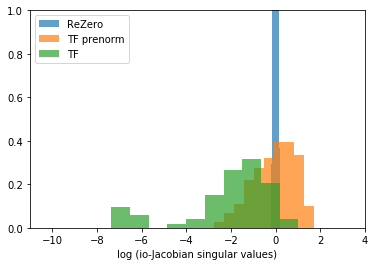

Jacobian mean squared singular values for  128  layer Transformers:
0.000 Vanilla Transformer (post norm)
870468043243477.875 Transformer with pre-norm
2.142 ReZero Transformer (resweight = 0.1)


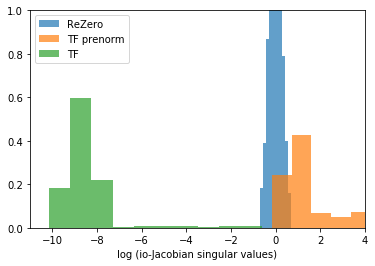

In [2]:
########################################################################
#Compare io-Jacobian singular values during training of deep Transformer and Deepformer encoders
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


########################################################################
#Define input-output Jacobian

def io_jacobian_TF(model, x):
    le = x.size()[0]
    emb = x.size()[2]
    noutputs = emb * le
    x = x.reshape(noutputs)
    x = x.repeat(noutputs,1)
    x.requires_grad_(True)
    y = model(x.reshape(emb*le,le,emb).transpose(0,1)).reshape(noutputs,-1)
    y.backward(torch.eye(noutputs).to(device))
    return x.grad.data


########################################################################
#Define an example deep transformer encoder network

class DeepEncoder(torch.nn.Module):

    def __init__(self, ninp, nhead, nhid, nlayers, dropout = 0, variant = 'ReZero', 
                 use_LayerNorm = False, init_resweight = 0):
        super(DeepEncoder, self).__init__()
        from torch.nn import TransformerEncoder
        if variant == 'ReZero':
            encoder_layers = ReZeroEncoderLayer(ninp, nhead, nhid, dropout, 
                                                use_LayerNorm = use_LayerNorm, init_resweight = init_resweight)
        else:
            encoder_layers = torch.nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self._reset_parameters()
        
    def forward(self, src):
        src = self.transformer_encoder(src)
        return src
    
    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""
        for p in self.parameters():
            #print(p.dim()>1)
            if p.dim() > 1:
                xavier_uniform_(p)
            
            
########################################################################
#Define a way to plot histograms of the singular value distributions

def plot_jacobians(layers = 128):
    d_TF = list()
    d_ReZero = list()
    d_TF_prenorm = list()

    torch.manual_seed(0)
    for i in range(10):
        src = torch.randn(length,1, emb).to(device)
        
        model = DeepEncoder(emb, nhead, nhid, layers, dropout, use_LayerNorm='post', init_resweight = 1
                           ).to(device)
        J = io_jacobian_TF(model,src)
        v, d, u = torch.svd(J)
        d_TF.append(d.cpu().numpy().tolist())

        model = DeepEncoder(emb, nhead, nhid, layers, dropout, use_LayerNorm='pre', init_resweight = 1
                           ).to(device)
        J = io_jacobian_TF(model,src)
        v, d, u = torch.svd(J)
        d_TF_prenorm.append(d.cpu().numpy().tolist())

        model = DeepEncoder(emb, nhead, nhid, layers, dropout, use_LayerNorm = False, init_resweight = .1
                           ).to(device)
        J = io_jacobian_TF(model,src)
        v, d, u = torch.svd(J)
        d_ReZero.append(d.cpu().numpy().tolist())

    d_TF = np.asarray(d_TF).flatten()
    d_TF_prenorm = np.asarray(d_TF_prenorm).flatten()
    d_ReZero = np.asarray(d_ReZero).flatten()

    print("%0.3f" % np.mean(d_TF**2),'Vanilla Transformer (post norm)')
    print("%3.3f" % np.mean(d_TF_prenorm**2), 'Transformer with pre-norm')
    print("%0.3f" % np.mean(d_ReZero**2),'ReZero Transformer (resweight = 0.1)')
    
    fig, ax = plt.subplots()
    opacity=.7
    plt.ylim((0,1))
    plt.xlim((-11,4))
    ax.hist(np.log(d_ReZero)/np.log(10), bins = 10, alpha = opacity, label='ReZero', density = True)
    ax.hist(np.log(d_TF_prenorm)/np.log(10), bins = 10, alpha = opacity, label='TF prenorm', density = True)
    ax.hist(np.log(d_TF)/np.log(10), bins = 10, alpha = opacity, label='TF', density = True)
    ax.legend(loc='upper left')
    ax.set_xlabel('log (io-Jacobian singular values)')
    plt.show()

    
########################################################################
#Use GPU if available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


########################################################################
#Plot singular value distributions for 12 and 128 layer networks

emb = 16
length = 4
nhead = 4
nhid = 64
dropout = 0

layers = 12
print('Jacobian mean squared singular values for ', layers, ' layer Transformers:')
plot_jacobians(layers = layers)

layers = 128
print('Jacobian mean squared singular values for ', layers, ' layer Transformers:')
plot_jacobians(layers = layers)

The blue/orange/green histograms correspond to the Rezero/Prenorm/vanilla Transformer architectures respectively. We observe that while for shallow (12 layer) networks all variants have many singular values close to one (i.e. log(1) = 0 in the figure), for deep networks both the vanilla as well as the prenorm versions have many large/small singular values. The ReZero Transformer maintains singular values much closer to one. We will see below how this affects the training dynamics for deep Transformer networks.

## 1.2 - Language modeling

We now use each of the three Transformer archtectures defined above to model the WikiText-2 dataset, following the basic PyTorch tutorial PyTorch tutorial [Sequence-to-Sequence Modeling with nn.Transformer and TorchText
](https://pytorch.org/tutorials/beginner/transformer_tutorial.html).  The model is tasked to predict which word will follow a sequence of words, and we refer to the tutorial for details.

We now define the `TransformerModel` and several functions that load and prepare the data. Finally, we arrive at the function `setup_and_train`, that defines, trains and evaluates the model, and takes the following parameters as input:

`encoder_version` : Defines Transformer architecture: `'ReZero'`, `'pre'`, or `'post'`.

`epochs` : Number of epochs to train
         
`lr` : Learning rate

`emsize` : Embedding size

`nhid` : Width of feed-forward layers

`nlayers` : Number of TransformerEncoder layers

`nhead` : Number of self attention heads

`dropout` : Dropout.

In [3]:
######################################################################
# Define the model

class TransformerModel(torch.nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.1, 
                 encoder_version = 'ReZero'):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        if encoder_version == 'ReZero':
            encoder_layers = ReZeroEncoderLayer(ninp, nhead, nhid, dropout, 
                activation = "relu", use_LayerNorm = False, init_resweight = 0, 
                resweight_trainable = True)
        elif encoder_version == 'pre':
            encoder_layers = ReZeroEncoderLayer(ninp, nhead, nhid, dropout, 
                activation = "relu", use_LayerNorm = 'pre', init_resweight = 1, 
                resweight_trainable = False)
        elif encoder_version == 'post':
            encoder_layers = ReZeroEncoderLayer(ninp, nhead, nhid, dropout, 
                activation = "relu", use_LayerNorm = 'post', init_resweight = 1, 
                resweight_trainable = False)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = torch.nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = torch.nn.Linear(ninp, ntoken)
        self._reset_parameters()
        self.init_weights()
        
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output
    

######################################################################
# Positional Encoding

class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


######################################################################
# Load and batch data

import torchtext
from torchtext.data.utils import get_tokenizer
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    
    data = TEXT.numericalize([data.examples[0].text])
    nbatch = data.size(0) // bsz
    data = data.narrow(0, 0, nbatch * bsz)
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 50
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)


######################################################################
# get_batch() function generates the input and target sequence for

bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target


######################################################################
# setup_and_train function calls, trains and evaluates the model

def setup_and_train(epochs, lr, emsize, nhid, nlayers, nhead, dropout, encoder_version, plt_jacobian = True):
    
    ntokens = len(TEXT.vocab.stoi)  # the size of vocabulary
    
    ######################################################################
    # Model setup

    model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, 
                             dropout, encoder_version = encoder_version).to(device)
    model.to(device)


    ######################################################################
    # Define criterion and optimizer

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adagrad(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.9)

    ######################################################################
    # Define the traiing

    def train():
        model.train() # Turn on the train mode
        total_loss = 0.
        start_time = time.time()
        ntokens = len(TEXT.vocab.stoi)
        for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
            data, targets = get_batch(train_data, i)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.view(-1, ntokens), targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            total_loss += loss.item()
            log_interval = 200
            if batch % log_interval == 0 and batch > 0:
                cur_loss = total_loss / log_interval
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | '
                      'lr {:02.2f} | ms/batch {:5.0f} | '
                      'loss {:5.2f} | ppl {:6.0f}'.format(
                        epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                        elapsed * 1000 / log_interval,cur_loss, math.exp(cur_loss)))
                total_loss = 0
                start_time = time.time()
                layer_count = 0
                weights = torch.zeros(nlayers)
                for name, param in model.named_parameters():
                    if name[27:] == f'{layer_count}'+'.resweight':
                        weights[layer_count] = param[0]
                        layer_count +=1

    ######################################################################
    # Define the evaluation

    def evaluate(eval_model, data_source):
        eval_model.eval() # Turn on the evaluation mode
        total_loss = 0.
        ntokens = len(TEXT.vocab.stoi)
        with torch.no_grad():
            for i in range(0, data_source.size(0) - 1, bptt):
                data, targets = get_batch(data_source, i)
                output = eval_model(data)
                output_flat = output.view(-1, ntokens)
                total_loss += len(data) * criterion(output_flat, targets).item()
        return total_loss / (len(data_source) - 1)

    ######################################################################
    # Train the model

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(model, val_data)
        print('-' * 88)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
              'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                         val_loss, math.exp(val_loss)))
        print('-' * 88)
        scheduler.step()

    ######################################################################
    #Plot the spectrum of the io-Jacobian singular values after training
    
    if plt_jacobian == True:
        d_ = list()
        for i in range(10):
            src = torch.randn(16,1, emsize).to(device)
            J = io_jacobian_TF(model.transformer_encoder,src)
            v, d, u = torch.svd(J)
            d_.append(d.cpu().numpy().tolist())
        d_ = np.asarray(d_).flatten()
        print('Mean sq singular value of io Jacobian:', "%0.3f" % np.mean(d_**2))
        fig, ax = plt.subplots()
        opacity=.7
        plt.ylim((0,1))
        plt.xlim((-11,4))
        ax.hist(np.log(d_)/np.log(10), bins = 10, alpha = opacity, label='Model.transformer_encoder',
                density = True)
        ax.legend(loc='upper left')
        ax.set_xlabel('log (io-Jacobian singular values)')
        plt.show()

We can now easily use the function `setup_and_train` to run experiments by changing between Transformer architectures and modifying hyperparameters.

First, let us use the `'post'` architecture that corresponds to a vanilla Transformer (i.e. we set `resweight = 1` and it is not trainable). Our experiment uses the Adagrad optimizer and no learning-rate warmup. For a 6 layer transformer network we observe slow training. 

| epoch   1 |   200/ 1192 batches | lr 0.01 | ms/batch    33 | loss  7.01 | ppl   1106
| epoch   1 |   400/ 1192 batches | lr 0.01 | ms/batch    32 | loss  6.89 | ppl    981
| epoch   1 |   600/ 1192 batches | lr 0.01 | ms/batch    33 | loss  6.89 | ppl    981
| epoch   1 |   800/ 1192 batches | lr 0.01 | ms/batch    33 | loss  6.78 | ppl    884
| epoch   1 |  1000/ 1192 batches | lr 0.01 | ms/batch    33 | loss  6.67 | ppl    788
----------------------------------------------------------------------------------------
| end of epoch   1 | time: 41.79s | valid loss  6.40 | valid ppl   599.31
----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1192 batches | lr 0.01 | ms/batch    33 | loss  6.41 | ppl    607
| epoch   2 |   400/ 1192 batches | lr 0.01 | ms/batch    33 | loss  6.32 | ppl    558
| epoch   2 |   600/ 1192 batches | lr 0.01 | ms/batch    33 | loss  6.26 | ppl    524
| epoch   2 |   800/ 1192 batches | lr 0.01 | ms/bat

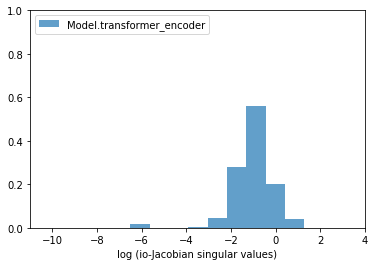

In [4]:
######################################################################
# The model is set up with the hyperparameter below.

encoder_version = 'post'      # architecture: 'ReZero', 'pre', or 'post' (vanilla)
nlayers = 6                     # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
lr = .01                        # Initial learning rate
epochs = 3                      # The number of epochs
emsize = 128                    # embedding dimension
nhid = 256                      # the dimension of the feedforward network model in nn.TransformerEncoder
nhead = 8                       # the number of heads in the multiheadattention models
dropout = 0.1                   # the dropout value

setup_and_train(epochs, lr, emsize, nhid, nlayers, nhead, dropout, encoder_version)

Next, let us use the `'pre'` architecture that applies the `LayerNorm` before the residual connection. For the 6 layer Transformer network with otherwise identical hyperparameters we observe faster training.

| epoch   1 |   200/ 1192 batches | lr 0.01 | ms/batch    34 | loss  7.37 | ppl   1583
| epoch   1 |   400/ 1192 batches | lr 0.01 | ms/batch    33 | loss  6.02 | ppl    410
| epoch   1 |   600/ 1192 batches | lr 0.01 | ms/batch    33 | loss  5.89 | ppl    363
| epoch   1 |   800/ 1192 batches | lr 0.01 | ms/batch    33 | loss  5.85 | ppl    348
| epoch   1 |  1000/ 1192 batches | lr 0.01 | ms/batch    33 | loss  5.78 | ppl    324
----------------------------------------------------------------------------------------
| end of epoch   1 | time: 42.67s | valid loss  5.50 | valid ppl   244.16
----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1192 batches | lr 0.01 | ms/batch    33 | loss  5.44 | ppl    231
| epoch   2 |   400/ 1192 batches | lr 0.01 | ms/batch    33 | loss  5.37 | ppl    215
| epoch   2 |   600/ 1192 batches | lr 0.01 | ms/batch    33 | loss  5.37 | ppl    216
| epoch   2 |   800/ 1192 batches | lr 0.01 | ms/bat

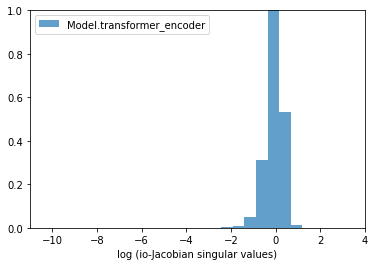

In [5]:
######################################################################
# The model is set up with the hyperparameter below.

encoder_version = 'pre'      # architecture: 'ReZero', 'pre', or 'post' (vanilla)
nlayers = 6                     # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
lr = .01                        # Initial learning rate
epochs = 3                      # The number of epochs
emsize = 128                    # embedding dimension
nhid = 256                      # the dimension of the feedforward network model in nn.TransformerEncoder
nhead = 8                       # the number of heads in the multiheadattention models
dropout = 0.1                   # the dropout value

setup_and_train(epochs, lr, emsize, nhid, nlayers, nhead, dropout, encoder_version)

Finally, we us use the `'ReZero'` architecture that eliminates the `LayerNorm` but set the residual weight initially to zero, and registers it as a trainable parameter. `ReZero` enables the use of a higher learning rate compared to the other architectures. For the 6 layer Transformer network with otherwise identical hyperparameters we observe the fastest training.

| epoch   1 |   200/ 1192 batches | lr 0.04 | ms/batch    32 | loss  7.03 | ppl   1134
| epoch   1 |   400/ 1192 batches | lr 0.04 | ms/batch    32 | loss  5.69 | ppl    297
| epoch   1 |   600/ 1192 batches | lr 0.04 | ms/batch    32 | loss  5.58 | ppl    264
| epoch   1 |   800/ 1192 batches | lr 0.04 | ms/batch    32 | loss  5.55 | ppl    256
| epoch   1 |  1000/ 1192 batches | lr 0.04 | ms/batch    32 | loss  5.47 | ppl    238
----------------------------------------------------------------------------------------
| end of epoch   1 | time: 41.55s | valid loss  5.33 | valid ppl   205.66
----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1192 batches | lr 0.03 | ms/batch    33 | loss  4.90 | ppl    135
| epoch   2 |   400/ 1192 batches | lr 0.03 | ms/batch    32 | loss  4.86 | ppl    129
| epoch   2 |   600/ 1192 batches | lr 0.03 | ms/batch    32 | loss  4.86 | ppl    129
| epoch   2 |   800/ 1192 batches | lr 0.03 | ms/bat

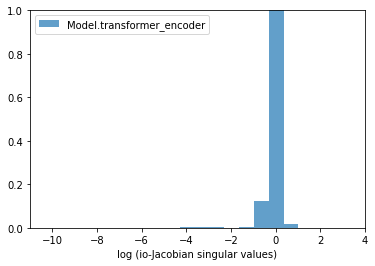

In [6]:
######################################################################
# The model is set up with the hyperparameter below.

encoder_version = 'ReZero'      # architecture: 'ReZero', 'pre', or 'post' (vanilla)
nlayers = 6                     # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
lr = .04                        # Initial learning rate
epochs = 3                      # The number of epochs
emsize = 128                    # embedding dimension
nhid = 256                      # the dimension of the feedforward network model in nn.TransformerEncoder
nhead = 8                       # the number of heads in the multiheadattention models
dropout = 0.1                   # the dropout value

setup_and_train(epochs, lr, emsize, nhid, nlayers, nhead, dropout, encoder_version)

As promised in the title, we can use the `'ReZero'` architecture to train extremely deep Transformer networks. To render a `128` layer transformer tranable, we again reduce the learning rate (to the Adagrad default value of `lr = 0.01`).

Training this 128 layer network takes about 20 minutes and after three epochs achieves a validation ppl of around `168`.

In [7]:
######################################################################
# The model is set up with the hyperparameter below.

encoder_version = 'ReZero'      # architecture: 'ReZero', 'pre', or 'post' (vanilla)
nlayers = 128                   # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
lr = .01                        # Initial learning rate
epochs = 3                      # The number of epochs
emsize = 128                    # embedding dimension
nhid = 256                      # the dimension of the feedforward network model in nn.TransformerEncoder
nhead = 8                       # the number of heads in the multiheadattention models
dropout = 0.1                   # the dropout value

setup_and_train(epochs, lr, emsize, nhid, nlayers, nhead, dropout, encoder_version, plt_jacobian = False)

| epoch   1 |   200/ 1192 batches | lr 0.01 | ms/batch   322 | loss  6.89 | ppl    985
| epoch   1 |   400/ 1192 batches | lr 0.01 | ms/batch   319 | loss  5.84 | ppl    344
| epoch   1 |   600/ 1192 batches | lr 0.01 | ms/batch   328 | loss  5.72 | ppl    304
| epoch   1 |   800/ 1192 batches | lr 0.01 | ms/batch   318 | loss  5.68 | ppl    292
| epoch   1 |  1000/ 1192 batches | lr 0.01 | ms/batch   324 | loss  5.59 | ppl    269
----------------------------------------------------------------------------------------
| end of epoch   1 | time: 427.25s | valid loss  5.35 | valid ppl   211.38
----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1192 batches | lr 0.01 | ms/batch   320 | loss  5.16 | ppl    174
| epoch   2 |   400/ 1192 batches | lr 0.01 | ms/batch   322 | loss  5.12 | ppl    167
| epoch   2 |   600/ 1192 batches | lr 0.01 | ms/batch   321 | loss  5.11 | ppl    166
| epoch   2 |   800/ 1192 batches | lr 0.01 | ms/ba